In [145]:
import random

import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn import metrics, preprocessing
from sklearn.metrics import ConfusionMatrixDisplay, classification_report
from sklearn.model_selection import StratifiedKFold, cross_val_score
from scikeras.wrappers import KerasClassifier


### DATABASE GENERATION

In [146]:
#data scaling
def normalization(data):
    # scaling
    # find min then max of dataset and then rescale --> mapping
    data_min = np.min(data)
    data_max = np.max(data)
    #rescaling
    scaling = (data - data_min) / (data_max - data_min)
    return scaling

def standardization(data):
    #Z score
    data_mean = np.mean(data)
    data_std = np.std(data)
    scaling = (data - data_mean)/data_std
    return scaling

In [240]:
import tensorflow as tf
from tensorflow import keras as k
synth_sig = np.random.normal(loc=0.01, scale=1, size=200)
synth_intro = np.zeros(shape=(50))

synth_data = np.append(synth_intro, synth_sig)


# design an anomaly
# ano_pos - where the anomaly happens
# ano_amp - signal intensity
# ano_rep - how many time it occurs
# ano_length - the duration of the anomaly
def rep_anno(sig_len, intro_len):
    #generates a random anomaly
    ano_pos = np.random.randint(low=intro_len + 30, high=sig_len - intro_len)
    ano_amp = np.random.randint(low=-3, high=+3)
    ano_len = np.random.randint(low=intro_len // 10, high=sig_len // 5)

    return ano_pos, ano_amp, ano_len


def generate_samples(sample_nr=10, ano_max_nr=2, sample_len=200):
    X = []
    y = []

    for _ in range(sample_nr):
        #signal data
        synth_sig = np.random.normal(loc=0.01, scale=1, size=sample_len)
        #signal intro
        synth_intro = np.zeros(shape=(50))

        synth_data = np.append(synth_intro, synth_sig)

        # 0 if the signal has no anomaly
        # 1 if the signal has an anomaly
        sign_good_or_bad = np.random.randint(0, 2)
        # y - label
        y_local = sign_good_or_bad

        if sign_good_or_bad == 1:
            #creates random anomalies in range ano_rep
            ano_rep = np.random.randint(1, ano_max_nr + 1)
            for _ in range(ano_rep):
                ano_pos, ano_amp, ano_len = rep_anno(len(synth_sig), len(synth_intro))
                ano_amp_data = np.ones(shape=(ano_len)) * ano_amp
                synth_data[ano_pos:ano_pos + ano_len] = ano_amp_data
        y.append(y_local)
        X.append(synth_data)
    X = np.array(X)
    y = np.array(y)
    return X, y

X_train, y_train = generate_samples(2500, 3, 300)

In [232]:
def data_augmentation(X,y):
    augmented_X = []
    augmented_y = []

    shift_amount = 2
    scaling_factor = 1.5
    noise_std = 0.1
    noise = np.random.normal(0, noise_std, size=len(X[0]))

    augmented_X.append(np.roll(X,shift_amount))
    augmented_y.append(y)
    augmented_X.append(X*scaling_factor)
    augmented_y.append(y)
    augmented_X.append(X+noise)
    augmented_y.append(y)

    return np.array(augmented_X), np.array(augmented_y)

In [241]:
print(X_train.shape[0],y_train.shape[0])
augmented_X, augmented_y = data_augmentation(X_train,y_train)
augmented_X = np.concatenate(augmented_X)
augmented_y =  np.concatenate(augmented_y)
X_train = np.concatenate((X_train, augmented_X),axis=0)
y_train = np.concatenate((y_train, augmented_y),axis=0)
print(X_train.shape[0],y_train.shape[0])
#
# print(augmented_X.shape[0],augmented_y.shape[0])
#plt.plot(augmented_X[0])
X_train = preprocessing.normalize(X_train)
# plt.hist(X_train)
# plt.xlabel("Numbers")
# plt.ylabel('Frequency')
# plt.title("Frequency of numbers")

2500 2500
10000 10000


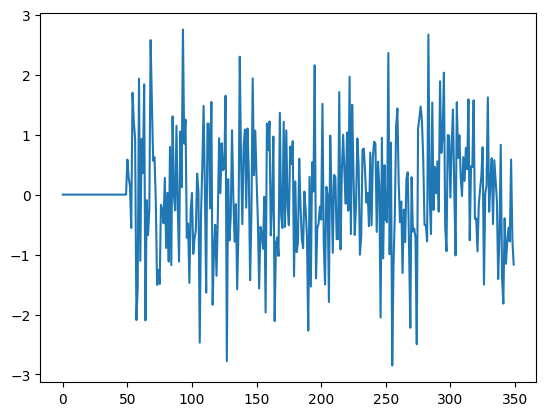

In [206]:
plt.plot(X_train[0])

In [ ]:
from sklearn.model_selection import KFold
cv = KFold(n_splits=10,shuffle=True,random_state=)

fold_no = 1
acc_per_fold = []


for train,test in cv.split(X_train, y_train):


    print('    ')
    print(f"Training for fold {fold_no} ...")

    epochs = 1000
    learning_rate = 0.0005
    validation_split = 0.2
    batch_size = 1800
    optimizer = k.optimizers.Adam(learning_rate=learning_rate)

    sig_shape =  len(X_train[0])
    data_in = k.Input(shape = (sig_shape,), name= "data_input")

    val = k.layers.Dense(units=20, name="dense1")(data_in)
    val = k.layers.BatchNormalization()(val)
    val = k.activations.relu(val)


    out = k.layers.Dense(units=1, name="out",activation='sigmoid')(val)

    model1 = k.Model(inputs=data_in,outputs=out)
    model1.compile(optimizer=optimizer,loss=k.losses.binary_crossentropy,metrics=['accuracy'])


    early_stopping = k.callbacks.EarlyStopping(monitor='val_loss', patience=3)
    model1.summary()
    hist = model1.fit(x=X_train,y=y_train,epochs=epochs,batch_size=batch_size, shuffle=True, validation_split=validation_split, callbacks=[early_stopping])

    model1.save('models/model_fold' + str(fold_no) + '.h5')

    score = model1.evaluate(test,)


### MODEL

Model: "model_66"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 data_input (InputLayer)     [(None, 350)]             0         
                                                                 
 dense1 (Dense)              (None, 40)                14040     
                                                                 
 batch_normalization_152 (Ba  (None, 40)               160       
 tchNormalization)                                               
                                                                 
 tf.nn.relu_152 (TFOpLambda)  (None, 40)               0         
                                                                 
 out (Dense)                 (None, 1)                 41        
                                                                 
Total params: 14,241
Trainable params: 14,161
Non-trainable params: 80
_____________________________________________________

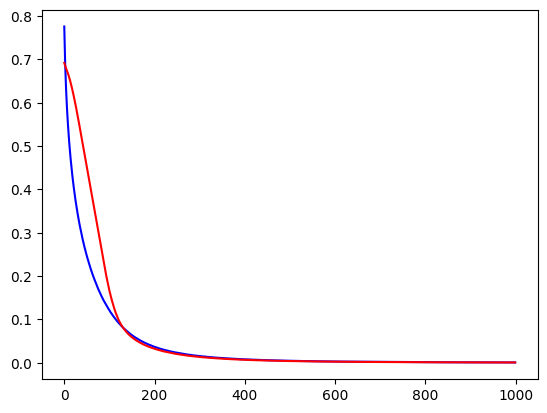

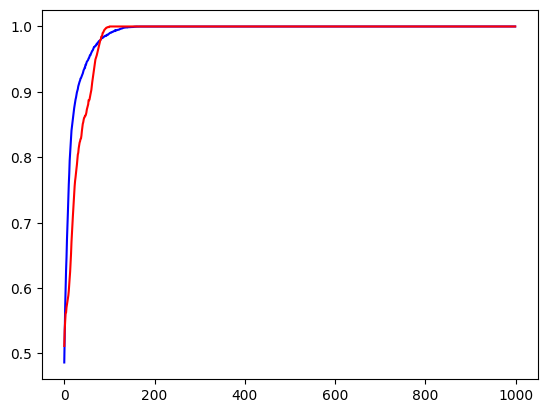

In [434]:
# Hyper-parameters
epochs = 1000
learning_rate = 0.0005
validation_split = 0.2
batch_size = 1800
optimizer = k.optimizers.Adam(learning_rate=learning_rate)

sig_shape =  len(X_train[0])
data_in = k.Input(shape = (sig_shape,), name= "data_input")

val = k.layers.Dense(units=40, name="dense1")(data_in)
val = k.layers.BatchNormalization()(val)
val = k.activations.relu(val)



out = k.layers.Dense(units=1, name="out",activation='sigmoid')(val)

model1 = k.Model(inputs=data_in,outputs=out)
model1.compile(optimizer=optimizer,loss=k.losses.binary_crossentropy,metrics=['accuracy'])


early_stopping = k.callbacks.EarlyStopping(monitor='val_loss', patience=2)
model1.summary()
hist = model1.fit(x=X_train,y=y_train,epochs=epochs,batch_size=batch_size, shuffle=True, validation_split=validation_split, callbacks=[early_stopping])
# Validation loss and training loss graphs
plt.plot(hist.history['loss'], c='b')
plt.plot(hist.history['val_loss'], c='r')
plt.show()
plt.plot(hist.history['accuracy'], c='b')
plt.plot(hist.history['val_accuracy'], c='r')



In [468]:
#dataset unbalanced
X_test, y_test = generate_samples(100,3,300)
X_test = preprocessing.normalize(X_test)
#print(test_data_y, test_data_X)
#print(len(test_data_y), len(test_data_X[0]))
# print(X_test.shape[0])

uX = []
uy = []
counter = 1
for i in range(X_test.shape[0]):
    #print(y[i])
    if counter % 2 == 0:
        if y_test[i] == 0:
            uX.append(X_test[i])
            uy.append(y_test[i])
    else:
         uX.append(X_test[i])
         uy.append(y_test[i])
    counter += 1
uX = preprocessing.normalize(np.array(uX))
uy = np.array(uy)

loss, accuracy = model1.evaluate(x=X_test,y=y_test,batch_size=100)
print(f"Loss:{loss}, Accuracy: {accuracy}")


loss, accuracy = model1.evaluate(x=uX,y=uy,batch_size=100)
print(f"Unbalance Loss :{loss}, Accuracy: {accuracy}")

1/1 [==============================] - 0s 29ms/step - loss: 0.4605 - accuracy: 0.8900
Loss:0.4604729413986206, Accuracy: 0.8899999856948853
1/1 [==============================] - 0s 28ms/step - loss: 0.3027 - accuracy: 0.8947
Unbalance Loss :0.3026678264141083, Accuracy: 0.8947368264198303


### ML COURSE 4

1/1 [==============================] - 0s 20ms/step
F1:  0.857142857142857
Accuracy:  0.87
Precision:  0.975
Recall:  0.7647058823529411
              precision    recall  f1-score   support

           0       0.80      0.98      0.88        49
           1       0.97      0.76      0.86        51

    accuracy                           0.87       100
   macro avg       0.89      0.87      0.87       100
weighted avg       0.89      0.87      0.87       100

1/1 [==============================] - 0s 31ms/step
F1:  0.8333333333333334
Accuracy:  0.8947368421052632
Precision:  0.9523809523809523
Recall:  0.7407407407407407
              precision    recall  f1-score   support

           0       0.87      0.98      0.92        49
           1       0.95      0.74      0.83        27

    accuracy                           0.89        76
   macro avg       0.91      0.86      0.88        76
weighted avg       0.90      0.89      0.89        76



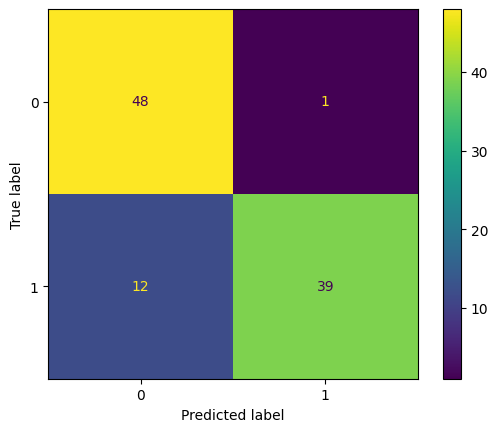

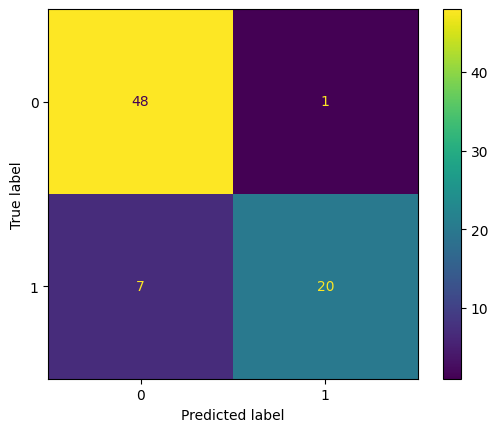

In [469]:

def limit(data):
    if data >= 0.9:
        ret = 1
    else:
        ret = 0
    return ret

def create_test_data(X, y):
    y_pred = []
    y_true = []
    for i in range(len(X)):
        signal_test = np.array([X[i]])

        ret = model1.predict(x=signal_test,batch_size=1)
        y_pred.append(limit(ret[0][0]))
        y_true.append(y[i])
    return y_true, y_pred


y_true, y_pred = create_test_data(X_test,y_test)
print("F1: ",metrics.f1_score(y_true,y_pred))
print("Accuracy: ",metrics.accuracy_score(y_true,y_pred))
print("Precision: ",metrics.precision_score(y_true,y_pred))
print("Recall: ",metrics.recall_score(y_true,y_pred))
print(classification_report(y_true,y_pred))
cfm = metrics.confusion_matrix(y_true,y_pred)
cfm_graph = ConfusionMatrixDisplay(cfm)
cfm_graph.plot()



y_true, y_pred = create_test_data(uX,uy)
print("F1: ",metrics.f1_score(y_true,y_pred))
print("Accuracy: ",metrics.accuracy_score(y_true,y_pred))
print("Precision: ",metrics.precision_score(y_true,y_pred))
print("Recall: ",metrics.recall_score(y_true,y_pred))
print(classification_report(y_true,y_pred))
cfm = metrics.confusion_matrix(y_true,y_pred)
cfm_graph = ConfusionMatrixDisplay(cfm)
cfm_graph.plot()

               Actual
            FALSE    TRUE
Pred False   TN      FN
Pred True    FP      TP

Accuracy: Tp/(TP+TN+FP+FN)
precision: TP/(TP+FP)
recall: TP/(TP+FN)
F1_score: 2*PR(P+R)


### Homework
* generate test dataset with "unseen" values, with 100 values
* work on model to get F1 score high for bit values (0,1) and achieve high values (0.8>>)
* if you want to see really how good your model is use unbalanced data
